#### This notebook gathers the relevant SNPs and compares the number of variants accumulated in each subject to the time between the collection of the longitudinal samples (that are confirmed treatment failure / relapse)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy
import datetime as dt
import statsmodels.api as sm

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Sample annotation for 200 filtered Subjects & corresponding isolates

#### Import annotation files for all samples

In [3]:
sample_annotation_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_sample_annotation_for_temporal_analysis.csv' , sep  = ',').set_index('patient_id')
sample_annotation_df.drop(labels = ['Unnamed: 0','isolate_type'] , axis = 1 , inplace = True)

In [4]:
sample_annotation_df.head()

,population,run_ID,sample_ID,sample_order,tag
patient_id,,,,,
2020E,BRYANT,ERR108130,400044.0,1,ERR108130
2020E,BRYANT,ERR108129,401206.0,2,ERR108129
2027W,BRYANT,ERR108131,400673.0,1,ERR108131
2027W,BRYANT,ERR108132,402568.0,2,ERR108132
2028K,BRYANT,ERR108133,400711.0,1,ERR108133


In [5]:
np.shape(sample_annotation_df)

(400, 5)

### *Subset* to subjects that had *confirmed delayed culture conversion/failure or relapse* cases

In [6]:
sample_annotation_neg_outcomes_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Table S2B confirmed delayed culture conversion failure or relapse.csv' , sep  = ',').set_index('Patient ID')
neg_outcome_cohort_patient_ids = list(set(sample_annotation_neg_outcomes_df[sample_annotation_neg_outcomes_df.negative_outcome_cohort == 'yes'].index))

In [7]:
len(neg_outcome_cohort_patient_ids)

121

In [8]:
sample_annotation_df = sample_annotation_df[[patient_id in neg_outcome_cohort_patient_ids for patient_id in sample_annotation_df.index]]

In [9]:
np.shape(sample_annotation_df)

(242, 5)

### Get the time between when each pair of subjects was collected

In [10]:
time_between_serial_isolate_collection = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_sample_annotation_for_temporal_analysis_with_dates.csv').set_index('population')
time_between_serial_isolate_collection.drop(labels = ['Unnamed: 0'] , axis = 1 , inplace = True)

In [11]:
time_between_serial_isolate_collection.head()

,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,
BRYANT,ERR108130,400044,1,ERR108130,longitudinal,2020E,0,NaN,NaN
BRYANT,ERR108129,401206,2,ERR108129,longitudinal,2020E,36,NaN,NaN
BRYANT,ERR108131,400673,1,ERR108131,longitudinal,2027W,0,NaN,NaN
BRYANT,ERR108132,402568,2,ERR108132,longitudinal,2027W,48,NaN,NaN
BRYANT,ERR108133,400711,1,ERR108133,longitudinal,2028K,0,NaN,NaN


In [12]:
np.shape(time_between_serial_isolate_collection)

(400, 9)

### *Subset* to subjects that had *confirmed delayed culture conversion/failure or relapse* cases

In [13]:
time_between_serial_isolate_collection = time_between_serial_isolate_collection[[patient_id in neg_outcome_cohort_patient_ids for patient_id in time_between_serial_isolate_collection.patient_id]]

In [14]:
np.shape(time_between_serial_isolate_collection)

(242, 9)

### *Filter* subjects based on isolate collection dates

#### Retain only patients that for which we have date Information for both samples

In [15]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 6] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 6] )

#get a boolean to check that there are dates for both samples
dates_for_both_samples = [ ( (isinstance(date_1, basestring)) and (isinstance(date_2, basestring)) ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [16]:
np.shape(time_between_serial_isolate_collection)

(238, 9)

In [17]:
np.shape(time_between_serial_isolate_collection_dropped )

(4, 9)

In [18]:
time_between_serial_isolate_collection_dropped 

,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,
WITNEY,ERR1750925,SAMEA23779168,1,ERR1750925,longitudinal,27,NaN,NaN,NaN
WITNEY,ERR1750926,SAMEA23779918,2,ERR1750926,longitudinal,27,1/25/11,NaN,NaN
WITNEY,ERR1750927,SAMEA23780668,1,ERR1750927,longitudinal,28,NaN,NaN,NaN
WITNEY,ERR1750928,SAMEA23781418,2,ERR1750928,longitudinal,28,8/3/11,NaN,NaN


#### Dropped 2 patients from Witney et. al. dataset that didn't have date information both both isolates - WITNEY:27 & WITNEY:28

In [19]:
patient_filter = []

for row_i in range(0 , np.shape(time_between_serial_isolate_collection)[0]):
    
    if time_between_serial_isolate_collection.iloc[row_i , 5] in list(sample_annotation_df.index):
        patient_filter.append(True)
        
    else:
        patient_filter.append(False)
    
time_between_serial_isolate_collection = time_between_serial_isolate_collection[patient_filter]

In [20]:
time_between_serial_isolate_collection.tail()

,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,
WITNEY,ERR1750886,SAMEA23749918,2,ERR1750886,longitudinal,7,3/8/10,NaN,NaN
WITNEY,ERR1750887,SAMEA23750668,1,ERR1750887,longitudinal,8,10/2/09,NaN,NaN
WITNEY,ERR1750888,SAMEA23751418,2,ERR1750888,longitudinal,8,4/12/10,NaN,NaN
XU,SRR3742658,SAMN05328093,1,SRR3742658,longitudinal,D,11/9/10,NaN,NaN
XU,SRR3742662,SAMN05328097,2,SRR3742662,longitudinal,D,1/1/13,NaN,NaN


#### Retain only patients that have different dates of collection for both samples

In [21]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 6] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 6] )

#get a boolean to check that there are dates for both samples
dates_different_for_both_samples = [ ( date_1 != date_2 ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_different_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [22]:
np.shape(time_between_serial_isolate_collection)

(238, 9)

In [23]:
np.shape(time_between_serial_isolate_collection_dropped )

(0, 9)

In [24]:
time_between_serial_isolate_collection_dropped 

,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,


#### Dropped 3 patients from Walker et. al. dataset that had the same date information both both isolates - WALKER:P000059, WALKER:P000259 & WALKER:P000267

In [25]:
patient_filter = []

for row_i in range(0 , np.shape(time_between_serial_isolate_collection)[0]):
    
    if time_between_serial_isolate_collection.iloc[row_i , 5] in list(sample_annotation_df.index):
        patient_filter.append(True)
        
    else:
        patient_filter.append(False)
    
time_between_serial_isolate_collection = time_between_serial_isolate_collection[patient_filter]

In [26]:
print 'Number of Patients = ' + str( np.shape(time_between_serial_isolate_collection)[0]/2 ) + ' with good isolate collection Date Information'

Number of Patients = 119 with good isolate collection Date Information


### Import SNPs from in-host SNP analysis

In [27]:
SNPS_from_all_patients_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_70.pkl')

In [28]:
SNPS_from_all_patients_DF.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L


In [29]:
np.shape(SNPS_from_all_patients_DF)

(175, 12)

### Get pairwise SNP distance for all longitudinal pairs

In [30]:
pairwise_variant_distances = pd.DataFrame(index = patients_to_keep , columns = ['population' , 'pairwise_SNP_distance' , 'time_between_collection'])

for patient_id in patients_to_keep:
    
    population = sample_annotation_df.loc[patient_id , 'population'].values[0]
    
    #pairwise distance between isolates; taking set ensures any SNPs in overlapping CDS regions will only be counted once
    SNP_distance = len(set( SNPS_from_all_patients_DF[SNPS_from_all_patients_DF.patient_id == patient_id].ref_position )) 
    
    #append info to dataframe
    pairwise_variant_distances.loc[patient_id , 'population'] = population
    pairwise_variant_distances.loc[patient_id , 'pairwise_SNP_distance'] = SNP_distance

In [31]:
pairwise_variant_distances.head()

,population,pairwise_SNP_distance,time_between_collection
2020E,BRYANT,3,NaN
2027W,BRYANT,5,NaN
2028K,BRYANT,0,NaN
2041Q,BRYANT,0,NaN
2043R,BRYANT,0,NaN


In [32]:
np.shape(pairwise_variant_distances)

(119, 3)

### Find distance between all pairs of times

In [33]:
for patient_id in pairwise_variant_distances.index:
    
    population = pairwise_variant_distances.loc[patient_id , 'population']
    patient_id = patient_id
    
    if population == 'BRYANT':
        
        bryant_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]
        
        first_date = bryant_pair[bryant_pair.sample_order == 1].date_information.values[0]
        second_date = bryant_pair[bryant_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
    
    if population == 'CASALI':
        
        casali_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = casali_pair[casali_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[0]
        month = first_date.split('/')[1]
        year = '20' + first_date.split('/')[2]
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = casali_pair[casali_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[0]
        month = second_date.split('/')[1]
        year = '20' + second_date.split('/')[2]
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'CETR') or (population == 'GUERRA') or (population == 'WITNEY') or (population == 'XU'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[1]
        month = first_date.split('/')[0]
        if int(first_date.split('/')[2]) in range(50,100): #some dates in 1990's others in 2000's
            year = '19' + first_date.split('/')[2]
        else:
            year = '20' + first_date.split('/')[2]

        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))


        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[1]
        month = second_date.split('/')[0]
        if int(second_date.split('/')[2]) in range(50,100):
            year = '19' + second_date.split('/')[2]
        else:
            year = '20' + second_date.split('/')[2]

        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'TRAUNER') or (population == 'BRYANT'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
        
    elif population == 'WALKER':
        
        walker_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = walker_pair[walker_pair.sample_order == 1].date_information.values[0]
        day = '1'
        month = '1'
        year = first_date
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = walker_pair[walker_pair.sample_order == 2].date_information.values[0]
        day = '1'
        month = '1'
        year = second_date
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    #append distance between isolate collection
    pairwise_variant_distances.loc[patient_id , 'time_between_collection'] = num_days_between

In [34]:
pairwise_variant_distances.head()

,population,pairwise_SNP_distance,time_between_collection
2020E,BRYANT,3,252
2027W,BRYANT,5,336
2028K,BRYANT,0,182
2041Q,BRYANT,0,182
2043R,BRYANT,0,252


#### convert time between isolate collection to months (30 days)

In [35]:
pairwise_variant_distances.loc[: , 'time_between_collection'] = pairwise_variant_distances.time_between_collection.astype(float) / 30.0
pairwise_variant_distances.loc[: , 'time_between_collection'] = [round(x, 2) for x in pairwise_variant_distances.time_between_collection] #round the nearest 2nd decimal place

In [36]:
pairwise_variant_distances.head()

,population,pairwise_SNP_distance,time_between_collection
2020E,BRYANT,3,8.40
2027W,BRYANT,5,11.20
2028K,BRYANT,0,6.07
2041Q,BRYANT,0,6.07
2043R,BRYANT,0,8.40


### Run OLS Regression by Regressing (Number of SNPs between Longitudinal Isolates) on (Number of Days between Isolate Collection)

In [37]:
#convert dataframe from integers to floats
pairwise_variant_distances = pairwise_variant_distances.apply(pd.to_numeric, errors='ignore')

#store the values in a dependent and independent vector 
Y = pairwise_variant_distances.pairwise_SNP_distance
X = pairwise_variant_distances.time_between_collection
X = sm.add_constant(X)

#run the OLS with statsmodels
model = sm.OLS(Y , X)
results = model.fit()

#store the fitted parameters from the regression
constant_from_OLS = results.params[0]
coeff_from_OLS = results.params[1]

#create a vector for the line using the output parameters from the OLS regression
X_values_line_best_fit = np.arange( min(pairwise_variant_distances.time_between_collection) , max(pairwise_variant_distances.time_between_collection) , 1)
Y_values_line_best_fit = coeff_from_OLS * X_values_line_best_fit + constant_from_OLS

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     pairwise_SNP_distance   R-squared:                       0.250
Model:                               OLS   Adj. R-squared:                  0.243
Method:                    Least Squares   F-statistic:                     38.93
Date:                   Fri, 11 Dec 2020   Prob (F-statistic):           7.24e-09
Time:                           02:07:07   Log-Likelihood:                -183.83
No. Observations:                    119   AIC:                             371.7
Df Residuals:                        117   BIC:                             377.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0161      0.146     -0.110      0.913      -0.306       0.274
time_between_collection     0.0533      0.009      6.240      0.000       0.036       0.070
==============================================================================
Omnibus:                       85.832   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              506.126
Skew:                           2.544   Prob(JB):                    1.25e-110
Kurtosis:                      11.729   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

coefficient of within-host SNPs regressed on Time between Isolate Collection

In [39]:
results.params[1]

0.05330330803552786

In [40]:
results.params[1] * 12 #SNPs / year

0.6396396964263343

p-values for coefficient on time

In [41]:
results.pvalues[1]

7.242909604331579e-09

74 / 175 SNPs represented in 119 confirmed failure/relapse subjects with isolation dates

In [42]:
int( pairwise_variant_distances.pairwise_SNP_distance.sum() )

74

### Plot (pairwise SNP distance) vs. (Time between Isolate Collection)

In [43]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

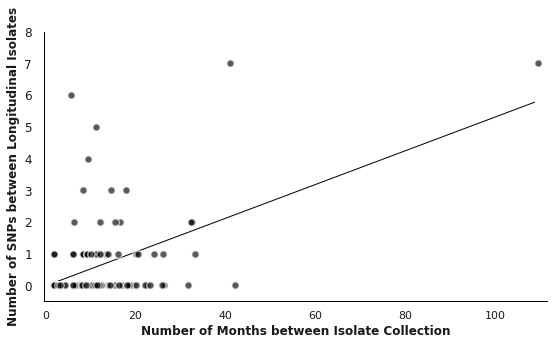

In [44]:
fig , ax = plt.subplots()

plt.scatter( pairwise_variant_distances.time_between_collection , pairwise_variant_distances.pairwise_SNP_distance , color = '0.0' , edgecolor = 'white' , linewidth = 1.5 , alpha = 0.65 , s = 55)

#plot Line of Best Fit from OLS regression
plt.plot(X_values_line_best_fit , Y_values_line_best_fit , color = '0.0' , linestyle = '-' , linewidth = 1.0 , zorder=0 , alpha = 1.0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_yscale("log", nonposy='clip')

ax.tick_params(labelcolor = 'k')
ax.set_ylim([min( pairwise_variant_distances.pairwise_SNP_distance ) - 1 , max( pairwise_variant_distances.pairwise_SNP_distance ) + 1])
ax.set_xlim([min( pairwise_variant_distances.time_between_collection ) - 2 , max( pairwise_variant_distances.time_between_collection ) + 2])

plt.ylabel('Number of SNPs between Longitudinal Isolates' , fontweight = 'bold', fontsize = 12 , color = 'k')
plt.xlabel('Number of Months between Isolate Collection' , fontweight = 'bold', fontsize = 12 , color = 'k')

#y-labels
ax.set_ylim([-0.5 , 8.0])
ax.set_yticks(np.arange(0 , 9 , 1))
y_labels = np.arange(0 , 9 , 1)
ax.set_yticklabels(y_labels, rotation='horizontal', fontsize = 12)  
ax.tick_params(axis='y', which='major', labelsize=12, pad = 6)

fig = plt.gcf()
fig.set_size_inches(8.0, 5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Sample_Summary/times_between_serial_isolate_collection_confirmed_failure_relapse.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()